In [1]:
import os
import sys
import torch as ch
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import torch
from robustness import model_utils, datasets, attacker
from robustness.tools.vis_tools import show_image_column
%matplotlib inline

from transfer_learning.tools import load_model_from_id

In [2]:
torch.cuda.set_device(6)

In [3]:
# Constants
DATA = 'ImageNet' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
IMAGENET_FOLDER = '/home/ubuntu/data/imagenet12'
BATCH_SIZE = 4
NUM_WORKERS = 8
NOISE_SCALE = 20

DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(IMAGENET_FOLDER)
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE // 2, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset imagenet..


In [8]:
model = load_model_from_id('megamix')
model = attacker.AttackerModel(model, dataset)
model.eval()

# Custom loss to maximize a given component of the representation vector
def feature_vis_loss(model, inp, targ):
    _, rep = model(inp, 
                   with_latent=True, 
                   fake_relu=True) #To propagate gradients through the "zero-region" of a ReLU activation
    loss = rep[:, targ]
    return loss, None

# PGD parameters
kwargs = {
    'custom_loss': feature_vis_loss,
    'constraint':'2',
    'eps':2000,
    'step_size': 4,
    'iterations': 300, 
    'use_best': False
}

# Seed image for feature visualization (1/2 test images, 1/2 noise)
_, (im, targ) = next(data_iterator)
im_n = ch.randn_like(im) / NOISE_SCALE + 0.5
ims = ch.cat([im, im_n])

# Maximize random activations for given seed images using PGD
act_list = np.random.randint(0, REPRESENTATION_SIZE, 5) # activations to visualize
result = [ims.cpu()]

model = model.cuda()
it = tqdm(enumerate(act_list))
for ii, i in it:
    it.set_description(f'{ii+1}/{len(act_list)}')
    _, xadv = model(ims.clone().cuda(), i, make_adv=True, **kwargs)
    result.append(xadv.detach().cpu())

1/5: : 0it [00:00, ?it/s]

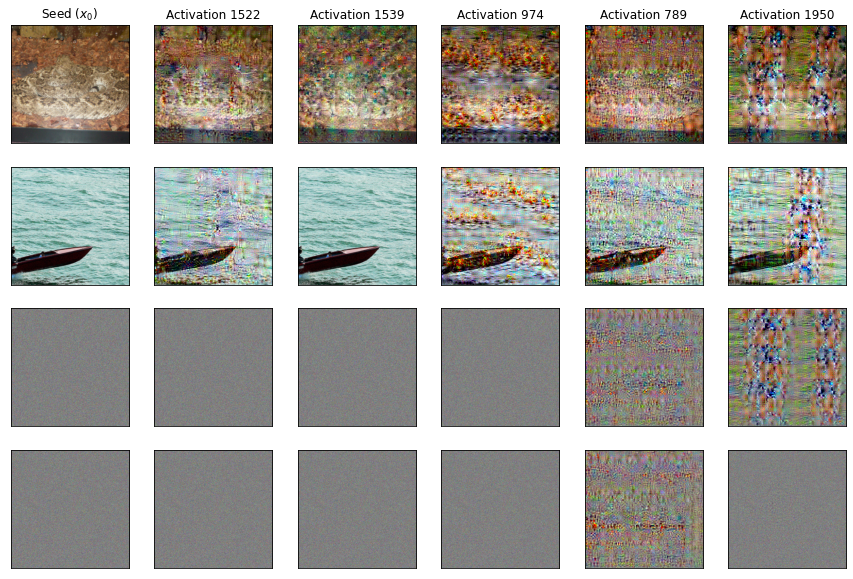

In [ ]:
# Feature Visualization results: Columns show seed image followed by result of maximizing specific feature
show_image_column(result, 
                  [r'Seed ($x_0$)'] + [f'Activation {i}' for i in act_list])